In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib import colors as mcolors
from scgenome import cncluster
from scdna_replication_tools.plot_utils import plot_cell_cn_profile2, plot_clustered_cell_cn_matrix, get_htert_cmap, plot_colorbar

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 0
despine_trim = True

### Load and preprocess data showing the fraction of replicated bins per S-phase cell

In [3]:
datasets = ['SA039', 'SA906a', 'SA906b', 'SA1188', 'SA1292', 'SA1054', 'SA1055', 'SA1056']
htert_rt = []

for d in datasets:
    temp_df = pd.read_csv('../../analysis/sig_lines/{}/scRT_pseudobulks.tsv'.format(d), sep='\t', usecols=['chr', 'start', 'pseudobulk_model_rep_state'])
    # add the dataset name as a column
    temp_df['dataset'] = d
    # append to the list
    htert_rt.append(temp_df)

htert_rt = pd.concat(htert_rt, ignore_index=True)
htert_rt.head()

,chr,start,pseudobulk_model_rep_state,dataset
0,1,1000001,0.947808,SA039
1,1,1500001,0.957550,SA039
2,1,2000001,0.959638,SA039
3,1,3000001,0.893528,SA039
4,1,4000001,0.788448,SA039


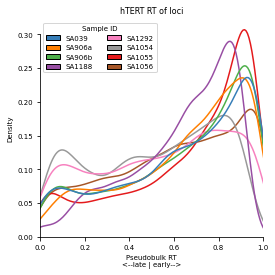

In [4]:
def plot_loci_rt_distribution(df, ax):
    htert_cmap = get_htert_cmap()
    df['sample'] = df['dataset']

    # plot both a histogram and kdeplot
    # sns.histplot(
    #     data=df, x='pseudobulk_model_rep_state', hue='sample', ax=ax, palette=htert_cmap,
    #     stat='density', bins=20, cbar_kws={'edgecolor': 'k', 'linewidth': 0}, kde=True,
    #     legend=False
    # )
    sns.kdeplot(
        data=df, x='pseudobulk_model_rep_state', hue='sample', ax=ax, palette=htert_cmap, legend=False
    )

    ax.set_xlabel('Pseudobulk RT\n<--late | early-->')
    ax.set_xlim(0, 1)
    ax.set_title('hTERT RT of loci')
    
    # generate handles and labels for the legend from the histplot
    # note that the ax.get_legend_handles_labels() returns empty labels for the histplot
    # so we need to manually generate the labels
    handles = []
    labels = []
    for i, d in enumerate(datasets):
        # plot the rectangle with the same saturation and border color as the histplot
        handle = plt.Rectangle((0,0),1,1, fc=htert_cmap[d], ec='k')
        handles.append(handle)
        labels.append(d)

    # plot the legend with two columns using the handles and labels from the histplot
    ax.legend(
        handles=handles, 
        labels=labels, 
        title='Sample ID',
        loc='upper left', ncol=2
    )
    
    sns.despine(ax=ax, offset=0, trim=despine_trim)


# plot the distribution of fraction of replicated bins for hTERT S-phase cells in the top right subplot
fig, ax = plt.subplots(1, 1, figsize=(4,4))
plot_loci_rt_distribution(htert_rt, ax)
plt.show()

### Load and preprocess the data which allows me to compare sample CNAs vs ancestral RT

In [5]:
def load_clone_rt_data(datasets, rt_paths):
    # load dataset pseudobulk rt profiles
    rt = pd.DataFrame()
    for d in datasets:
        temp_rt = pd.read_csv(rt_paths.format(d), sep='\t')
        # set chr and start as the index columns
        temp_rt = temp_rt.set_index(['chr', 'start'])
        # subset to only the columns containing 'clone' and 'model_rep_state' substrings
        temp_rt = temp_rt[[c for c in temp_rt.columns if 'clone' in c and 'model_rep_state' in c]]
        # add the dataset d as the prefix for all the column names
        temp_rt = temp_rt.add_prefix('{}_'.format(d))
        # remove the 'pseudobulk_' substring from the column names
        temp_rt = temp_rt.rename(columns={c: c.replace('pseudobulk_', '') for c in temp_rt.columns})
        # replace the 'model_rep_state' substring with 'pseudobulk_rt' in the column names
        temp_rt = temp_rt.rename(columns={c: c.replace('model_rep_state', 'pseudobulk_rt') for c in temp_rt.columns})
        
        # reset the index
        temp_rt = temp_rt.reset_index()
        if rt.empty:
            rt = temp_rt
        else:
            rt = pd.merge(rt, temp_rt)

    # set chr column to category
    rt.chr = rt.chr.astype('str').astype('category')

    rt['end'] = rt['start'] + 500000 - 1
            
    return rt
    

def load_clone_cn_data(datasets, cn_paths):
    # load dataset pseudobulk cn profiles
    cn = pd.DataFrame()

    for d in datasets:
        temp_cn = pd.read_csv(cn_paths.format(d), sep='\t')

        # set chr and start as the index columns
        temp_cn = temp_cn.set_index(['chr', 'start'])
        # subset to only the columns containing 'clone' and 'model_rep_state' substrings
        temp_cn = temp_cn[[c for c in temp_cn.columns if 'clone' in c]]
        # add the dataset d as the prefix for all the column names
        temp_cn = temp_cn.add_prefix('{}_'.format(d))
        # replace the 'clone_' substring with 'clone' in the column names
        temp_cn = temp_cn.rename(columns={c: c.replace('clone_', 'clone') for c in temp_cn.columns})
        # add the '_pseudobulk_cn' suffix to the column names
        temp_cn = temp_cn.rename(columns={c: '{}_pseudobulk_cn'.format(c) for c in temp_cn.columns})

        # reset the index
        temp_cn = temp_cn.reset_index()
        
        if cn.empty:
            cn = temp_cn
        else:
            cn = pd.merge(cn, temp_cn)


    # set chr column to category
    cn.chr = cn.chr.astype('str').astype('category')

    cn['end'] = cn['start'] + 500000 - 1

    return cn

In [6]:
def make_bk_clones(cn, clones):
    # create a table of copy number breakpoints for sample pseudobulk data
    # copy over the chromosome, start, and end columns
    cn_breakpoints = cn[['chr', 'start', 'end']].copy()
    for c in clones:
        # create a column for the copy number breakpoints
        cn_breakpoints['{}_pseudobulk_cn_breakpoints'.format(c)] = cn['{}_pseudobulk_cn'.format(c)].diff().fillna(0).astype('int')
        # convert all nonzero values to 1
        cn_breakpoints['{}_pseudobulk_cn_breakpoints'.format(c)] = cn_breakpoints['{}_pseudobulk_cn_breakpoints'.format(c)].apply(lambda x: 1 if x!=0 else 0)

    return cn_breakpoints


def compute_relative_rt_and_cn_clones(cn, rt, clones):
    for c in clones:
        ref_rt_col = 'SA039_cloneA_pseudobulk_rt'
        ref_cn_col = 'SA039_cloneA_pseudobulk_cn'
        
        temp_rt_col = '{}_pseudobulk_rt'.format(c)
        temp_cn_col = '{}_pseudobulk_cn'.format(c)
        
        relative_rt_col = '{}_pseudobulk_relative_rt'.format(c)
        relative_cn_col = '{}_pseudobulk_relative_cn'.format(c)
        
        rt[relative_rt_col] = rt[temp_rt_col] - rt[ref_rt_col]
        cn[relative_cn_col] = (cn[temp_cn_col] / cn[temp_cn_col].mode().values[0]) - (cn[ref_cn_col] / cn[ref_cn_col].mode().values[0])
    
    return cn, rt


def merge_cn_and_rt_info_clones(cn, rt, bk, clones):
    # merge the cn and rt tables into one long-form dataframe
    df = []

    for c in clones:
        ref_rt_col = 'SA039_cloneA_pseudobulk_rt'
        ref_cn_col = 'SA039_cloneA_pseudobulk_cn'
        
        temp_rt_col = '{}_pseudobulk_rt'.format(c)
        temp_cn_col = '{}_pseudobulk_cn'.format(c)
        temp_bk_col = '{}_pseudobulk_cn_breakpoints'.format(c)
        
        relative_rt_col = '{}_pseudobulk_relative_rt'.format(c)
        relative_cn_col = '{}_pseudobulk_relative_cn'.format(c)
        
        temp_df = pd.DataFrame({
            'chr': cn['chr'], 'start': cn['start'], 'end': cn['end'], 'clone': [c]*cn.shape[0],
            'WT_pseudobulk_rt': rt[ref_rt_col], 'WT_pseudobulk_cn': cn[ref_cn_col],
            'pseudobulk_rt': rt[temp_rt_col], 'pseudobulk_cn': cn[temp_cn_col], 'pseudobulk_bk': bk[temp_bk_col],
            'relative_rt': rt[relative_rt_col], 'relative_cn': cn[relative_cn_col]
        })
        
        df.append(temp_df)

    df = pd.concat(df, ignore_index=True)

    return df

In [7]:
datasets = [
    'SA039', 'SA906a', 'SA906b', 'SA1292', 'SA1056', 'SA1188', 'SA1054', 'SA1055'
]
rt_paths = '../../analysis/sig_lines/{}/scRT_pseudobulks.tsv'
cn_paths = '../../analysis/sig_lines/{}/cn_pseudobulks.tsv'

# load the rt and cn data
rt_clone = load_clone_rt_data(datasets, rt_paths)
cn_clone = load_clone_cn_data(datasets, cn_paths)

# remove the site of p53 deletion on chr17
chr17_start_thresh = 21000001
cn_clone = cn_clone.loc[~((cn_clone['chr'] == '17') & (cn_clone['start'] <= chr17_start_thresh))]
rt_clone = rt_clone.loc[~((rt_clone['chr'] == '17') & (rt_clone['start'] <= chr17_start_thresh))]
rt_clone.head()

,chr,start,SA039_cloneA_pseudobulk_rt,SA039_cloneB_pseudobulk_rt,SA039_cloneC_pseudobulk_rt,SA039_cloneD_pseudobulk_rt,SA906a_cloneA_pseudobulk_rt,SA906a_cloneB_pseudobulk_rt,SA906a_cloneC_pseudobulk_rt,SA906a_cloneD_pseudobulk_rt,...,SA1055_cloneB_pseudobulk_rt,SA1055_cloneC_pseudobulk_rt,SA1055_cloneD_pseudobulk_rt,SA1055_cloneE_pseudobulk_rt,SA1055_cloneF_pseudobulk_rt,SA1055_cloneG_pseudobulk_rt,SA1055_cloneH_pseudobulk_rt,SA1055_cloneI_pseudobulk_rt,SA1055_cloneJ_pseudobulk_rt,end
0,1,1000001,0.944694,0.954,0.935065,1.000000,0.829268,0.785714,0.533333,0.909375,...,0.5,1.0,1.000000,0.8,0.8,1.0,1.0,0.914286,1.0,1500000
1,1,1500001,0.949178,0.968,0.952381,1.000000,0.959350,0.878571,0.866667,0.943750,...,0.5,1.0,0.833333,0.6,0.6,1.0,1.0,0.885714,1.0,2000000
2,1,2000001,0.955157,0.968,0.952381,0.972973,0.878049,0.828571,0.555556,0.900000,...,0.5,1.0,1.000000,0.8,0.8,1.0,1.0,0.914286,1.0,2500000
3,1,3000001,0.877429,0.910,0.891775,0.972973,0.878049,0.707143,0.577778,0.843750,...,0.5,1.0,1.000000,0.8,0.6,1.0,1.0,0.771429,1.0,3500000
4,1,4000001,0.765321,0.830,0.753247,0.864865,0.878049,0.757143,0.755556,0.743750,...,0.5,1.0,1.000000,0.6,0.6,1.0,1.0,0.771429,0.8,4500000


In [8]:
cn_clone.head()

,chr,start,SA039_cloneA_pseudobulk_cn,SA039_cloneB_pseudobulk_cn,SA039_cloneC_pseudobulk_cn,SA039_cloneD_pseudobulk_cn,SA906a_cloneA_pseudobulk_cn,SA906a_cloneB_pseudobulk_cn,SA906a_cloneC_pseudobulk_cn,SA906a_cloneD_pseudobulk_cn,...,SA1055_cloneB_pseudobulk_cn,SA1055_cloneC_pseudobulk_cn,SA1055_cloneD_pseudobulk_cn,SA1055_cloneE_pseudobulk_cn,SA1055_cloneF_pseudobulk_cn,SA1055_cloneG_pseudobulk_cn,SA1055_cloneH_pseudobulk_cn,SA1055_cloneI_pseudobulk_cn,SA1055_cloneJ_pseudobulk_cn,end
0,1,1000001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,1500000
1,1,1500001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,2000000
2,1,2000001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,2500000
3,1,3000001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,3500000
4,1,4000001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,4500000


In [9]:
htert_clones = [c.replace('_pseudobulk_cn', '') for c in cn_clone.set_index(['chr', 'start', 'end']).columns.tolist()]

# make a table of copy number breakpoints
bk_clone = make_bk_clones(cn_clone, htert_clones)

# compute the relative RT and CN values for each dataset
cn_clone, rt_clone = compute_relative_rt_and_cn_clones(cn_clone, rt_clone, htert_clones)

# merge the cn and rt tables into one long-form dataframe
df_clone = merge_cn_and_rt_info_clones(cn_clone, rt_clone, bk_clone, htert_clones)

# create column to denote whether a particular bin has a gain, loss, or no cna
df_clone['cna_type'] = 'unaltered'
for i, row in df_clone.iterrows():
    if row['relative_cn'] > 0:
        df_clone.loc[i, 'cna_type'] = 'gain'
    elif row['relative_cn'] < 0:
        df_clone.loc[i, 'cna_type'] = 'loss'

# rename bk column
df_clone['breakpoint'] = df_clone['pseudobulk_bk'].replace({0: 'No', 1: 'Yes'})
df_clone.head()

,chr,start,end,clone,WT_pseudobulk_rt,WT_pseudobulk_cn,pseudobulk_rt,pseudobulk_cn,pseudobulk_bk,relative_rt,relative_cn,cna_type,breakpoint
0,1,1000001,1500000,SA039_cloneA,0.944694,2.0,0.944694,2.0,0,0.0,0.0,unaltered,No
1,1,1500001,2000000,SA039_cloneA,0.949178,2.0,0.949178,2.0,0,0.0,0.0,unaltered,No
2,1,2000001,2500000,SA039_cloneA,0.955157,2.0,0.955157,2.0,0,0.0,0.0,unaltered,No
3,1,3000001,3500000,SA039_cloneA,0.877429,2.0,0.877429,2.0,0,0.0,0.0,unaltered,No
4,1,4000001,4500000,SA039_cloneA,0.765321,2.0,0.765321,2.0,0,0.0,0.0,unaltered,No


In [10]:
# re-orient cn_clone to be amenable for plotting a CN matrix instead of multiple CN profiles
cn_matrix = cn_clone.copy()
cn_matrix['end'] = cn_matrix['start'] + 500000 - 1
# set chr, start as the index
cn_matrix = cn_matrix.set_index(['chr', 'start', 'end'])
# subset to only include the columns with 'relative_cn' substring
cn_matrix = cn_matrix[[c for c in cn_matrix.columns if 'relative_cn' in c]]

# melt the dataframe to long-form such that the value column name is 'relative_cn' and the variable column name is 'cell_id'
cn_matrix = cn_matrix.reset_index().melt(id_vars=['chr', 'start', 'end'], value_vars=cn_matrix.columns, var_name='cell_id', value_name='relative_cn')
# the first prefix of the cell_id column corresponds to the sample name
cn_matrix['sample_id'] = cn_matrix['cell_id'].apply(lambda x: x.split('_')[0])
# the second prefix of the cell_id column corresponds to the clone name
cn_matrix['clone_id'] = cn_matrix['cell_id'].apply(lambda x: x.split('_')[1])
cn_matrix.head()

,chr,start,end,cell_id,relative_cn,sample_id,clone_id
0,1,1000001,1500000,SA039_cloneA_pseudobulk_relative_cn,0.0,SA039,cloneA
1,1,1500001,2000000,SA039_cloneA_pseudobulk_relative_cn,0.0,SA039,cloneA
2,1,2000001,2500000,SA039_cloneA_pseudobulk_relative_cn,0.0,SA039,cloneA
3,1,3000001,3500000,SA039_cloneA_pseudobulk_relative_cn,0.0,SA039,cloneA
4,1,4000001,4500000,SA039_cloneA_pseudobulk_relative_cn,0.0,SA039,cloneA


In [11]:
len(htert_clones)

61

In [12]:
def get_cna_cmap():
    ''' Global color map for copy number alterations '''
    cmap = {
        'gain': 'red',  # red
        'loss': 'deepskyblue',  # dark blue
        'neutral': '#CCCCCC',  # grey
        'unaltered': '#CCCCCC'  # grey
    }
    return cmap

In [48]:
def ancestral_rt_vs_clone_cna_histogram(df, ax):
    # histogram of RT values split by CNA type
    df['CNA type'] = df['cna_type']
    sns.histplot(
        data=df, x='WT_pseudobulk_rt', hue='CNA type', 
        common_norm=False, stat='density', ax=ax, kde=True, bins=20,
        palette=get_cna_cmap(), cbar_kws={'edgecolor': 'k', 'linewidth': 0}
    )
    ax.set_xlabel('Ancestral hTERT RT\n<--late | early-->')
    ax.set_title('Location of clone CNAs')

    # compute a p-value for the difference in RT between bins with different CNA types
    # multiply each p-value by 2 because we are doing 2 pairwise comparisons (bonferonni correction)
    gain = df.query('`CNA type`=="gain"')['WT_pseudobulk_rt']
    unaltered = df.query('`CNA type`=="unaltered"')['WT_pseudobulk_rt']
    loss = df.query('`CNA type`=="loss"')['WT_pseudobulk_rt']
    gain_unaltered_pval = stats.ttest_ind(gain, unaltered)[1] * 2
    loss_unaltered_pval = stats.ttest_ind(loss, unaltered)[1] * 2

    # add p-values to plot
    ax.text(0.05, 0.62, 'p={:.2e}'.format(gain_unaltered_pval), transform=ax.transAxes, ha='left', va='center', color=get_cna_cmap()['gain'])
    ax.text(0.05, 0.55, 'p={:.2e}'.format(loss_unaltered_pval), transform=ax.transAxes, ha='left', va='center', color=get_cna_cmap()['loss'])

    sns.despine(ax=ax, trim=True, offset=0)


def plot_clone_cn_profiles(cn, ax_cn, ax_sample, chrom_labels_to_remove=[], sample_cmap=get_htert_cmap()):
    # sort rows of cn by sample_id according to the order of SA039, SA906a, SA906b, SA1188, SA1292, SA1054, SA1055, SA1056
    # do this by first converting sample_id to a category and then sorting by the category
    cn['sample_id'] = cn['sample_id'].astype('category')
    cn['sample_id'] = cn['sample_id'].cat.set_categories(['SA039', 'SA906a', 'SA906b', 'SA1188', 'SA1292', 'SA1054', 'SA1055', 'SA1056'])
    cn = cn.sort_values('sample_id')
    cn['sample_id'] = cn['sample_id'].astype('str')

    # create mapping of clones to cluster ids
    cluster_col = 'cluster_id'
    sample_dict = dict([(y,x+1) for x,y in enumerate(cn['sample_id'].unique())])
    cn[cluster_col] = cn['sample_id']
    cn = cn.replace({cluster_col: sample_dict})

    plot_data = plot_clustered_cell_cn_matrix(
        ax_cn, cn, 'relative_cn', cluster_field_name=cluster_col, secondary_field_name='clone_id',
        raw=True, max_cn=None, cmap='bwr', chromosome=None, chrom_boundary_width=1, chrom_labels_to_remove=chrom_labels_to_remove,
        vmin=-1, vmax=1
    )

    # hide the y-ticks and labels for all heatmaps
    for ax in [ax_cn, ax_sample]:
        ax.set_yticks([])
        ax.set_yticklabels([])

    # add a colorbar on the left column that represents the sample_id of each unique clone
    if len(sample_dict) > 1:
        # annotate the clones for G1-phase cells
        # cell_ids = plot_data.columns.get_level_values(0).values
        cluster_ids0 = plot_data.columns.get_level_values(1).values
        # use mcolors to change every element in the dict to rgba
        sample_cmap2 = {}
        for key in sample_dict.keys():
            sample_cmap2[sample_dict[key]] = mcolors.to_rgba(sample_cmap[key])
        color_mat, _ = cncluster.get_cluster_colors(cluster_ids0, color_map=sample_cmap2, return_map=True)

        # get list of color pigments in the same order as sample_dict
        colors_used = []
        for c in color_mat:
            if c not in colors_used:
                colors_used.append(c)

        # create color bar that shows clone id for each row in heatmap
        plot_colorbar(ax_sample, color_mat)

    ax_cn.set_title('Ploidy-normalized clone CN profiles')
    ax_sample.set_ylabel('{} unique clones'.format(cn.cell_id.nunique()))


def plot_profiles(cn, rt, ax_cn, ax_sample, ax_rt, chrom_labels_to_remove=[], sample_cmap=get_htert_cmap()):
    # plot the reference RT profile and the relative CN profiles for each dataset
    # get the reference pseudobulk rt column
    ref_rt_col = 'SA039_cloneA_pseudobulk_rt'
    # create a dummy columns for cell_id and clone_id in the rt dataframe
    rt['cell_id'] = 'SA039_cloneA'
    rt['clone_id'] = 'SA039_cloneA'
    rt['sort_order'] = 0
    plot_data = plot_clustered_cell_cn_matrix(
        ax_rt, rt, ref_rt_col, cluster_field_name='clone_id', secondary_field_name='sort_order',
        raw=True, max_cn=None, cmap='viridis', chrom_boundary_width=1, chrom_labels_to_remove=chrom_labels_to_remove,
        vmin=0, vmax=1
    )
    ax_rt.set_title('Ancestral hTERT RT (SA039 clone A)')
    ax_rt.set_yticks([])
    ax_rt.set_yticklabels([])

    # plot a heatmap of the relative CN profiles for each clone
    plot_clone_cn_profiles(cn, ax_cn, ax_sample, chrom_labels_to_remove=chrom_labels_to_remove, sample_cmap=sample_cmap)
    ax_cn.set_xlabel('chromosome')

    

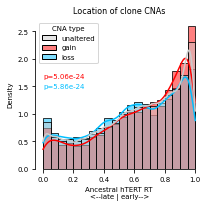

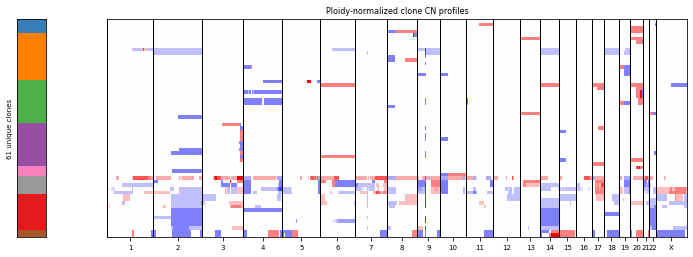

In [35]:
# plot the ancestral_rt_vs_clone_cna_histogram
fig, ax = plt.subplots(1, 1, figsize=(3, 2.75))
ancestral_rt_vs_clone_cna_histogram(df_clone, ax)
plt.show()

# plot the clone cn profiles
# create two subplots in one row, two columns where the first column is 1/20th the width of the second column
fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 20]})
plot_clone_cn_profiles(cn_matrix, ax[1], ax[0])
plt.show()

### Plot the relationship between the clone CNA breakpoints and the ancestral RT

In [36]:
def get_bkpt_cmap():
    cmap = {
        'No': 'grey', # grey
        False: 'grey', # grey
        'Yes': 'C2', # green
        True: 'C2' # green
    }
    return cmap

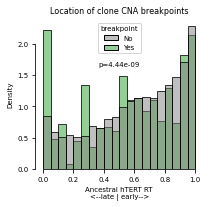

In [37]:
def ancestral_rt_vs_clone_bk_histogram(df, ax):
    # histogram of RT values split by breakpoint presence
    sns.histplot(
        data=df_clone, x='WT_pseudobulk_rt', hue='breakpoint', 
        common_norm=False, stat='density', ax=ax,
        palette=get_bkpt_cmap(), bins=20
    )
    ax.set_xlabel('Ancestral hTERT RT\n<--late | early-->')
    ax.set_title('Location of clone CNA breakpoints')

    # compute a p-value for the difference in RT between bins with different CNA types
    # multiply each p-value by 3 because we are doing 3 pairwise comparisons (bonferonni correction)
    yes = df.query('`breakpoint`=="Yes"')['WT_pseudobulk_rt']
    no = df.query('`breakpoint`=="No"')['WT_pseudobulk_rt']
    pval = stats.ttest_ind(yes, no)[1]

    # add p-values to plot
    ax.text(0.5, 0.7, 'p={:.2e}'.format(pval), transform=ax.transAxes, ha='center', va='center')
   
    sns.despine(ax=ax, trim=True, offset=0)

fig, ax = plt.subplots(1, 1, figsize=(3, 2.75))
ancestral_rt_vs_clone_bk_histogram(df_clone, ax)
plt.show()

### Plot the distribution of RT shifts in gains, losses and neutral CNAs


In [38]:
rt_diffs = pd.read_csv('../../analysis/sig_lines/subclonal_rt_diffs_summary.tsv', sep='\t')

# filter this dataframe to only consider CNAs that have >95% frequency within their given clone
rt_diffs = rt_diffs[rt_diffs['clone_freq'] > 0.98]

rt_diffs.head()

,chr,start,end,reference_rt,clone_rt,clone_rt_diff,clone_cna_type,reference_freq,clone_freq,dataset
1,11,66500001,67000000,1.209055,1.135885,-0.073170,gain,0.997333,0.994350,SA039
2,11,67000001,67500000,1.206959,1.129149,-0.077809,gain,0.997333,0.996234,SA039
3,11,67500001,68000000,1.134819,1.088738,-0.046081,gain,0.997333,0.996234,SA039
4,11,68000001,68500000,1.105117,1.061797,-0.043321,gain,0.997333,0.996234,SA039
5,11,68500001,69000000,0.867831,0.853002,-0.014828,gain,0.997706,0.998117,SA039


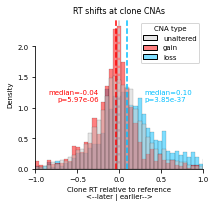

In [39]:
def plot_rt_shift_hist_per_bin(df, ax):
    # instead of a violin plot, show the histogram of clone_rt_diff with a hue of clone_cna_type
    df['CNA type'] = df['clone_cna_type']
    sns.histplot(
        data=df, x='clone_rt_diff', hue='CNA type', hue_order=['unaltered', 'gain', 'loss'], 
        palette=get_cna_cmap(), common_norm=False, stat='density', ax=ax,
        bins=120, rasterized=True
    )
    ax.set_xlim(-1, 1)
    ax.set_xticks(np.arange(-1, 1.5, 0.5))

    # compute the p-values between loss-unaltered and gain-unaltered
    # get the y-values for the loss-unaltered and gain-unaltered comparisons
    loss = df[df.clone_cna_type == 'loss'].clone_rt_diff
    unaltered = df[df.clone_cna_type == 'unaltered'].clone_rt_diff
    gain = df[df.clone_cna_type == 'gain'].clone_rt_diff
    # compute the p-value between loss-unaltered and gain-unaltered
    # multiply each p-value by 2 because we are doing 2 pairwise comparisons (bonferonni correction)
    loss_unaltered_pval = stats.ttest_ind(loss, unaltered)[1] * 2
    gain_unaltered_pval = stats.ttest_ind(gain, unaltered)[1] * 2

    # annotate the median of each distribution with a dashed vertical line
    # annotate the line with the median value as text with 2 decimal places
    text_offset = 0.2
    text_height = 1.2
    loss_median = df[df.clone_cna_type=='loss'].clone_rt_diff.median()
    ax.axvline(x=loss_median, color=get_cna_cmap()['loss'], linestyle='--')
    ax.text(x=loss_median+text_offset, y=text_height, s='median={:.2f}\np={:.2e}'.format(loss_median, loss_unaltered_pval), color=get_cna_cmap()['loss'], ha='left', va='center')
    unaltered_median = df[df.clone_cna_type=='unaltered'].clone_rt_diff.median()
    ax.axvline(x=unaltered_median, color=get_cna_cmap()['unaltered'], linestyle='--')
    # ax.text(x=unaltered_median, y=10, s='median={:.2f}'.format(unaltered_median), color=get_cna_cmap()['unaltered'], ha='left', va='center')
    gain_median = df[df.clone_cna_type=='gain'].clone_rt_diff.median()
    ax.axvline(x=gain_median, color=get_cna_cmap()['gain'], linestyle='--')
    ax.text(x=gain_median-text_offset, y=text_height, s='median={:.2f}\np={:.2e}'.format(gain_median, gain_unaltered_pval), color=get_cna_cmap()['gain'], ha='right', va='center')

    ax.set_title('RT shifts at clone CNAs')

    ax.set_xlabel('Clone RT relative to reference\n<--later | earlier-->')

    sns.despine(ax=ax, trim=True, offset=0)


fig, ax = plt.subplots(1, 1, figsize=(3, 2.75))
plot_rt_shift_hist_per_bin(rt_diffs, ax)
plt.show()

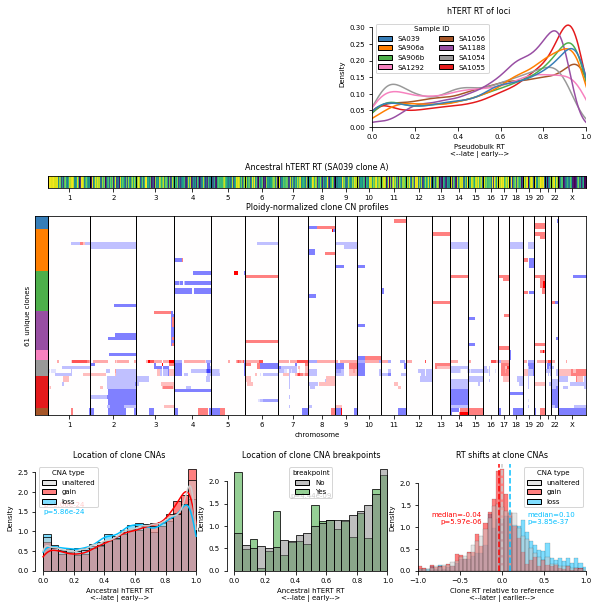

In [51]:
mult_factor = 1.0
fig = plt.figure(figsize=(8.5/mult_factor, 8.5/mult_factor))
chrom_labels_to_remove = ['21']

# add a subplot in the top right of the figure to show the distribution of RT values for hTERT S-phase cells
ax0 = fig.add_axes([0.6, 0.775, 0.35, 0.175])

# add a subplot for the ancestral RT profile below subplot
ax1 = fig.add_axes([0.07, 0.675, 0.88, 0.02])

# add a subplot for the CN matrix below RT profile above and a seperate subplot for the colorbar
ax2 = fig.add_axes([0.05, 0.305, 0.02, 0.325])
ax3 = fig.add_axes([0.07, 0.305, 0.88, 0.325])

# add three subplots on the bottom row of the figure to represent the histograms of RT values
ax4 = fig.add_axes([0.05, 0.05, 0.275, 0.175])
ax5 = fig.add_axes([0.3625, 0.05, 0.275, 0.175])
ax6 = fig.add_axes([0.675, 0.05, 0.275, 0.175])

# plot the distribution of fraction of replicated bins for hTERT S-phase cells in the top right subplot
plot_loci_rt_distribution(htert_rt, ax0)

# plot the ancestral rt in the 2nd row and clone cn profiles in the 3rd row
plot_profiles(cn_matrix, rt_clone, ax3, ax2, ax1, chrom_labels_to_remove=chrom_labels_to_remove)

# plot the histogram of ancestral RT values split by CNA type in the bottom left subplot
ancestral_rt_vs_clone_cna_histogram(df_clone, ax4)

# plot the histogram of ancestral RT values split by breakpoint presence in the bottom middle subplot
ancestral_rt_vs_clone_bk_histogram(df_clone, ax5)

# plot the histogram of clone RT shifts split by CNA type in the bottom right subplot
plot_rt_shift_hist_per_bin(rt_diffs, ax6)

# draw a dashed lines around the boundaries of the entire figure to know where to crop
# ax_bottom = fig.add_axes([0, 0, 1, 0.01])
# ax_top = fig.add_axes([0, 0.99, 1, 0.01])
# ax_left = fig.add_axes([0, 0, 0.01, 1])
# ax_right = fig.add_axes([0.99, 0, 0.01, 1])
# for ax in [ax_bottom, ax_top, ax_left, ax_right]:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

plt.show()

In [ ]:
# # create figure
# fig, ax = plt.subplots(4, 3, figsize=(8.5, 11), tight_layout=True)

# chrom_labels_to_remove = ['21']

# # merge the 3 subplots in the 2nd row
# ax[1, 0].remove()
# ax[1, 1].remove()
# ax[1, 2].remove()
# ax[1, 0] = fig.add_subplot(4, 3, (4, 6))

# # merge the 3 subplots in the 3rd row
# ax[2, 0].remove()
# ax[2, 1].remove()
# ax[2, 2].remove()
# ax[2, 0] = fig.add_subplot(4, 3, (7, 9))

# # make the top left and top middle plots invisible
# ax[0, 0].set_visible(False)
# ax[0, 1].set_visible(False)

# # plot the distribution of fraction of replicated bins for hTERT S-phase cells in the top right subplot
# plot_loci_rt_distribution(htert_rt, ax[0, 2])

# # plot the ancestral rt in the 2nd row and clone cn profiles in the 3rd row
# plot_profiles(cn_clone, rt_clone, htert_clones, ax[2, 0], ax[1, 0], chrom_labels_to_remove=chrom_labels_to_remove)

# # plot the histogram of ancestral RT values split by CNA type in the bottom left subplot
# ancestral_rt_vs_clone_cna_histogram(df_clone, ax[3, 0])

# # plot the histogram of ancestral RT values split by breakpoint presence in the bottom middle subplot
# ancestral_rt_vs_clone_bk_histogram(df_clone, ax[3, 1])

# # plot the histogram of clone RT shifts split by CNA type in the bottom right subplot
# plot_rt_shift_hist_per_bin(rt_diffs, ax[3, 2])

# # fig.savefig('../../manuscript/main_figs/fig3.pdf', bbox_inches='tight', dpi=300)

# plt.show()